In [1]:
import pandas as pd
import numpy as np
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, log_loss, f1_score, precision_recall_curve, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler

import imblearn
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#settings
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=np.inf)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
# init_notebook_mode(connected=True)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 
seed = 123

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('/content/drive/My Drive/Metis/data/processed/df1.pkl', 'rb') as read_file:
    df1 = pickle.load(read_file)

In [21]:
df1['dti'] = df1['dti'].astype(np.float32)
df1['revol_bal'] = df1['revol_bal'].astype(np.float64)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886426 entries, 0 to 886425
Data columns (total 33 columns):
id                                   886426 non-null int32
loan_amnt                            886426 non-null float64
annual_inc                           886426 non-null int32
term_label_encoded                   886426 non-null int64
installment                          886426 non-null float64
grade_label_encoded                  886426 non-null int8
home_ownership_label_encoded         886426 non-null int64
verification_status_label_encoded    886426 non-null int64
purpose_label_encoded                886426 non-null int64
dti                                  886426 non-null float32
delinq_2yrs_imputed                  886426 non-null float32
inq_last_6mths_imputed               886426 non-null float32
mths_since_last_delinq_imputed       886426 non-null float32
mths_since_last_record_imputed       886426 non-null float32
open_acc_imputed                     886426 non-nu

In [0]:
with open('/content/drive/My Drive/Metis/data/processed/X_train_val_1.pkl', 'rb') as read_file:
    X_train_val_1 = pickle.load(read_file)
with open('/content/drive/My Drive/Metis/data/processed/y_train_val.pkl', 'rb') as read_file:
    y_train_val = pickle.load(read_file)
with open('/content/drive/My Drive/Metis/data/processed/X_test_1.pkl', 'rb') as read_file:
    X_test_1 = pickle.load(read_file)
with open('/content/drive/My Drive/Metis/data/processed/y_test.pkl', 'rb') as read_file:
    y_test = pickle.load(read_file)

In [0]:
X_train_val_1['dti'] = X_train_val_1['dti'].astype(np.float32)
X_test_1['dti'] = X_test_1['dti'].astype(np.float)
X_train_val_1['revol_bal'] = X_train_val_1['revol_bal'].astype(np.float32)
X_test_1['revol_bal'] = X_test_1['revol_bal'].astype(np.float)

In [0]:
X_train_val_1.describe()

,loan_amnt,annual_inc,term_label_encoded,installment,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,dti,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_bal,revol_util_imputed,total_acc_imputed
count,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,7.091400e+05,709140.000000,709140.000000
mean,14764.709825,74548.343769,0.300135,436.985462,2.902121,1.027625,2.568797,18.136300,0.314271,0.694237,34.044281,70.563263,11.549430,1.691481e+04,55.072800,25.272493
std,8436.583167,47840.921504,0.458317,244.184536,1.921980,0.792656,2.277899,8.296871,0.861937,0.997287,15.275887,11.049717,5.310398,2.191090e+04,23.817125,11.846057
min,500.000000,1896.000000,0.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,8000.000000,45000.000000,0.000000,260.850000,1.000000,0.000000,2.000000,11.910000,0.000000,0.000000,32.000000,70.124985,8.000000,6.451000e+03,37.700001,17.000000
50%,13000.000000,65000.000000,0.000000,382.550000,4.000000,1.000000,2.000000,17.670000,0.000000,0.000000,34.067402,70.124985,11.000000,1.187900e+04,56.000000,24.000000
75%,20000.000000,90000.000000,1.000000,572.850000,5.000000,2.000000,2.000000,23.960000,0.000000,1.000000,34.067402,70.124985,14.000000,2.084200e+04,73.599998,32.000000
max,35000.000000,998000.000000,1.000000,1445.460000,5.000000,2.000000,13.000000,39.990000,39.000000,32.000000,180.000000,129.000000,90.000000,2.904836e+06,892.299988,162.000000


In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886426 entries, 0 to 886425
Data columns (total 33 columns):
id                                   886426 non-null int32
loan_amnt                            886426 non-null float64
annual_inc                           886426 non-null int32
term_label_encoded                   886426 non-null int64
installment                          886426 non-null float64
grade_label_encoded                  886426 non-null int8
home_ownership_label_encoded         886426 non-null int64
verification_status_label_encoded    886426 non-null int64
purpose_label_encoded                886426 non-null int64
dti                                  886426 non-null float16
delinq_2yrs_imputed                  886426 non-null float32
inq_last_6mths_imputed               886426 non-null float32
mths_since_last_delinq_imputed       886426 non-null float32
mths_since_last_record_imputed       886426 non-null float32
open_acc_imputed                     886426 non-nu

In [0]:
categorical_feature = ['term_label_encoded', 'home_ownership_label_encoded',
       'verification_status_label_encoded', 'purpose_label_encoded' ]
model_features = ['loan_amnt', 'annual_inc', 'term_label_encoded', 'installment',
       'home_ownership_label_encoded', 'verification_status_label_encoded',
       'purpose_label_encoded', 'dti', 'delinq_2yrs_imputed', 'inq_last_6mths_imputed',
       'mths_since_last_delinq_imputed', 'mths_since_last_record_imputed', 'open_acc_imputed',
       'revol_bal', 'revol_util_imputed', 'total_acc_imputed']
y = df1['bad_loan']
X_1 = df1[model_features]
    
X_train_val_1, X_test_1, y_train_val, y_test = train_test_split(X_1, y, test_size=0.2,random_state=seed,stratify=y)
X_train_1, X_val_1, y_train, y_val = train_test_split(X_train_val_1, y_train_val, test_size=.25, random_state=seed,stratify=y_train_val)

In [0]:
X_train_val_1_sample = X_train_val_1.sample(frac=0.05, replace=False, random_state=seed)
X_test_1_sample = X_test_1.sample(frac=0.05, replace=False, random_state=seed)
y_train_val_sample = y_train_val.sample(frac=0.05, replace=False, random_state=seed)
y_test_sample = y_test.sample(frac=0.05, replace=False, random_state=seed)
    
# X_gbt_train_val_1_sample, X_gbt_test_1_sample, y_gbt_train_val_sample, y_gbt_test_sample = train_test_split(X_gbt_1_sample, y_gbt_sample, test_size=0.2,random_state=seed,stratify=y_gbt_sample)
# X_gbt_train_1_sample, X_gbt_val_1_sample, y_gbt_train_sample, y_gbt_val_sample = train_test_split(X_gbt_train_val_1_sample, y_gbt_train_val_sample, test_size=.25, random_state=seed,stratify=y_gbt_train_val_sample)

In [0]:
X_train_val_1_sample.describe()

,loan_amnt,annual_inc,term_label_encoded,installment,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,dti,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_bal,revol_util_imputed,total_acc_imputed
count,35457.000000,35457.000000,35457.000000,35457.000000,35457.000000,35457.000000,35457.000000,35457.000000,35457.000000,35457.00000,35457.000000,35457.000000,35457.000000,3.545700e+04,35457.000000,35457.000000
mean,14774.371069,74608.271174,0.298756,437.640278,2.893336,1.030431,2.601433,18.097122,0.314155,0.69298,34.046444,70.158348,11.518148,1.700292e+04,55.212826,25.262205
std,8470.660044,47270.747339,0.457719,245.745854,1.922023,0.793386,2.318839,8.258688,0.865815,0.99443,15.260019,11.011642,5.307019,2.205317e+04,23.627604,11.776803
min,600.000000,3600.000000,0.000000,19.870000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,1.000000
25%,8000.000000,45000.000000,0.000000,260.410000,1.000000,0.000000,2.000000,11.950000,0.000000,0.00000,31.000000,70.124985,8.000000,6.464000e+03,38.000000,17.000000
50%,13000.000000,64227.000000,0.000000,382.870000,1.000000,1.000000,2.000000,17.670000,0.000000,0.00000,34.067402,70.124985,11.000000,1.193200e+04,56.099998,24.000000
75%,20000.000000,90000.000000,1.000000,573.310000,5.000000,2.000000,2.000000,23.850000,0.000000,1.00000,34.067402,70.124985,14.000000,2.079000e+04,73.500000,32.000000
max,35000.000000,980000.000000,1.000000,1407.010000,5.000000,2.000000,13.000000,39.990000,27.000000,24.00000,156.000000,119.000000,70.000000,1.030826e+06,153.000000,124.000000


In [0]:
df1['bad_loan'].value_counts().values[0]/df1['bad_loan'].value_counts().values[1]

12.156796390298929

In [0]:
df1['bad_loan'].value_counts()

0    819052
1    67374 
Name: bad_loan, dtype: int64

Random forest

In [0]:
random_grid = {'max_depth': [3,5,8,10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'class_weight':[{0:1,1:12.156796390298929}]}
 
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier() , scoring = 'f1', param_distributions = random_grid
                               , n_iter = 10, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed), verbose=50, random_state=seed, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_val_1_sample, y_train_val_sample)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 18.6min
[Paralle

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spli...
                   pa

{'class_weight': {0: 1, 1: 12.156796390298929},
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1400}

In [0]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 12.156796390298929},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_cv_model_1 = rf_random.best_estimator_.fit(X_train_val_1, y_train_val)
y_rf_test_preds_1 = rf_cv_model_1.predict(X_test_1)

In [0]:
rf_os_1 = rf_random.best_estimator_
with open('/content/drive/My Drive/Metis/models/rf_os_1.pkl', 'wb') as to_write:
    pickle.dump(rf_os_1, to_write)

In [0]:
print("RF test results:")
print("Default threshold:")
print(metrics.classification_report(y_test, y_rf_test_preds_1))

print("ROC AUC score = ", roc_auc_score(y_test, y_rf_test_preds_1))
print("RF Test confusion matrix: \n\n", confusion_matrix(y_test, y_rf_test_preds_1))

print("\n")
print("Log-loss on RF: {:6.4f}".format(log_loss(y_test, y_rf_test_preds_1)))

print("\n")
print('f1 score:',f1_score(y_test, y_rf_test_preds_1))

RF test results:
Default threshold:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73    163811
           1       0.11      0.62      0.19     13475

    accuracy                           0.59    177286
   macro avg       0.53      0.61      0.46    177286
weighted avg       0.89      0.59      0.69    177286

ROC AUC score =  0.6050880332032043
RF Test confusion matrix: 

 [[96574 67237]
 [ 5112  8363]]


Log-loss on RF: 14.0953


f1 score: 0.1877743474600056


In [0]:
print("RF Test Feature Importance: \n\n", sorted(list(zip(X_test_1.columns, rf_cv_model_1.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))


In [0]:
print("RF Test Feature Importance: \n\n", sorted(list(zip(X_test_1.columns, rf_cv_model_1.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))

RF Test Feature Importance: 

 [('inq_last_6mths_imputed', 0.32), ('annual_inc', 0.18), ('verification_status_label_encoded', 0.14), ('revol_util_imputed', 0.12), ('term_label_encoded', 0.07), ('purpose_label_encoded', 0.07), ('home_ownership_label_encoded', 0.04), ('loan_amnt', 0.01), ('installment', 0.01), ('dti', 0.01), ('mths_since_last_record_imputed', 0.01), ('revol_bal', 0.01), ('delinq_2yrs_imputed', 0.0), ('mths_since_last_delinq_imputed', 0.0), ('open_acc_imputed', 0.0), ('total_acc_imputed', 0.0)]


In [0]:
df1.head(3)

,id,loan_amnt,annual_inc,term_label_encoded,installment,grade_label_encoded,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,dti,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_bal,revol_util_imputed,total_acc_imputed,income_category,loan_condition,loan_amnt_scaled,annual_inc_scaled,installment_scaled,dti_scaled,delinq_2yrs_scaled,inq_last_6mths_scaled,mths_since_last_delinq_scaled,mths_since_last_record_scaled,open_acc_scaled,revol_bal_scaled,revol_util_scaled,total_acc_scaled,bad_loan
0,1077501,5000.0,24000,0,162.87,1,5,2,1,27.65625,0.0,1.0,34.067402,70.124985,3.0,13648.0,83.699997,9.0,1,1,0.130435,0.022190,0.102952,0.691423,0.0,0.030303,0.18121,0.543605,0.033333,0.004698,0.093803,0.047619,0
1,1077430,2500.0,30000,1,59.83,2,5,1,0,1.00000,0.0,5.0,34.067402,70.124985,3.0,1687.0,9.400000,4.0,1,0,0.057971,0.028214,0.030886,0.025006,0.0,0.151515,0.18121,0.543605,0.033333,0.000581,0.010535,0.017857,1
2,1077175,2400.0,12252,0,84.33,2,5,0,11,8.71875,0.0,2.0,34.067402,70.124985,2.0,2956.0,98.500000,10.0,1,1,0.055072,0.010397,0.048021,0.218055,0.0,0.060606,0.18121,0.543605,0.022222,0.001018,0.110389,0.053571,0


In [0]:
# with open('/content/drive/My Drive/Metis/data/processed/df1.pkl', 'wb') as to_write:
#     pickle.dump(df1, to_write)

In [0]:
# LGBM hyperparameter randomised gridsearch
lgbm_grid_parameters = {
    "objective" : ['binary'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], #Regularise. shrinkage_rate
    "max_depth":[3,5,8],
    "criterion": ["auc", "binary_logloss"],
    "feature_fraction" : [0.4, 0.5, 0.6, 0.7], #Decorrelate trees. randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. 
    "n_estimators":[100, 200, 300, 400, 500,600,700,800,900,1000], #num of trees
    "num_leaves" : [10,20,30,40,50,60,70,80], # num_leaf per estimator/tree,
    "min_data_in_leaf":[10,20,30,40,50], #i.e. min_child_samples 
    "min_split_gain" : [0.1, 0.5],
    "random_state" : [seed]}


In [0]:


# scoring = {'AUC': make_scorer(auc), 'Log Loss': "binary_logloss"}
lgbm_clf = lgb.LGBMClassifier()
lgbm_finder = RandomizedSearchCV(lgbm_clf, lgbm_grid_parameters,
    n_jobs=-1,
    refit='AUC',
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed),  
    verbose=50,
    return_train_score=False )

In [0]:
lgbm_finder.fit(X_train_val_1_sample, y_train_val_sample,categorical_feature = categorical_feature, feature_name = model_features)

#this returns a dict of the parameter setting that gave the best results on the hold out data
print('Best score reached: {} with params: {} '.format(lgbm_finder.best_score_, lgbm_finder.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   1

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership_label_encoded', 'purpose_label_encoded', 'term_label_encoded', 'verification_status_label_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=...
                                        'feature_fraction': [0.4, 0.5, 0.6,
                                                             0.7],
                                        'learning_rat

Best score reached: 0.9216233760087519 with params: {'random_state': 123, 'objective': 'binary', 'num_leaves': 50, 'n_estimators': 500, 'min_split_gain': 0.1, 'min_data_in_leaf': 10, 'max_depth': 5, 'learning_rate': 0.01, 'feature_fraction': 0.7, 'criterion': 'binary_logloss'} 


In [0]:
start = time.time()
lgbm_cv_model_1 = lgbm_finder.best_estimator_.fit(X_train_val_1, y_train_val,
        eval_set=[(X_train_val_1, y_train_val),(X_test_1, y_test)],
        eval_metric=['auc', 'binary_logloss'],
        early_stopping_rounds=200,
        verbose=50)

end = time.time()
print('Total time spent: {}'.format(end-start))

Training until validation scores don't improve for 200 rounds.
[50]	training's binary_logloss: 0.263733	training's auc: 0.660847	training's binary_logloss: 0.263733	valid_1's binary_logloss: 0.263892	valid_1's auc: 0.658183	valid_1's binary_logloss: 0.263892
[100]	training's binary_logloss: 0.260782	training's auc: 0.666164	training's binary_logloss: 0.260782	valid_1's binary_logloss: 0.26111	valid_1's auc: 0.662314	valid_1's binary_logloss: 0.26111
[150]	training's binary_logloss: 0.258785	training's auc: 0.671002	training's binary_logloss: 0.258785	valid_1's binary_logloss: 0.259283	valid_1's auc: 0.666147	valid_1's binary_logloss: 0.259283
[200]	training's binary_logloss: 0.257333	training's auc: 0.675038	training's binary_logloss: 0.257333	valid_1's binary_logloss: 0.257994	valid_1's auc: 0.669477	valid_1's binary_logloss: 0.257994
[250]	training's binary_logloss: 0.256276	training's auc: 0.677799	training's binary_logloss: 0.256276	valid_1's binary_logloss: 0.257084	valid_1's auc:

In [0]:
y_1_gbt_test_pred= lgbm_finder.best_estimator_.predict(X_test_1)

print("LGBM bad loan test results:")
print("Default threshold:")
print(metrics.classification_report(y_test, y_1_gbt_test_pred))

print("ROC AUC score = ", roc_auc_score(y_test, lgbm_finder.best_estimator_.predict_proba(X_test_1)[:,1]))
print("LGBM Test confusion matrix: \n\n", confusion_matrix(y_test, y_1_gbt_test_pred))

print("\n")
print("LGBM Test Feature Importance: \n\n", sorted(list(zip(X_test_1.columns, lgbm_finder.best_estimator_.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))

print("\n")
print("Log-loss on LGBM: {:6.4f}".format(log_loss(y_test, lgbm_finder.best_estimator_.predict_proba(X_test_1)[:,1])))

print("\n")
print('f1 score:',f1_score(y_test, y_1_gbt_test_pred))

LGBM bad loan test results:
Default threshold:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    163811
           1       0.33      0.00      0.00     13475

    accuracy                           0.92    177286
   macro avg       0.63      0.50      0.48    177286
weighted avg       0.88      0.92      0.89    177286

ROC AUC score =  0.6829584281872241
LGBM Test confusion matrix: 

 [[163807      4]
 [ 13473      2]]


LGBM Test Feature Importance: 

 [('installment', 2303), ('annual_inc', 1810), ('revol_util_imputed', 1480), ('revol_bal', 1416), ('loan_amnt', 1397), ('purpose_label_encoded', 1108), ('mths_since_last_record_imputed', 977), ('inq_last_6mths_imputed', 844), ('dti', 752), ('verification_status_label_encoded', 702), ('term_label_encoded', 684), ('mths_since_last_delinq_imputed', 535), ('total_acc_imputed', 516), ('open_acc_imputed', 444), ('home_ownership_label_encoded', 355), ('delinq_2yrs_imputed', 103)]


Log-loss o

In [0]:
NN_X_1 = df1.filter(regex='scaled',axis=1).columns.values.tolist() + df1.filter(regex='label_encoded',axis=1).columns.values.tolist()
NN_X_1 = ['loan_amnt_scaled',\
 'annual_inc_scaled',\
 'installment_scaled',\
 'dti_scaled',\
 'delinq_2yrs_scaled',\
 'inq_last_6mths_scaled',\
 'mths_since_last_delinq_scaled',\
 'mths_since_last_record_scaled',\
 'open_acc_scaled',\
 'revol_bal_scaled',\
 'revol_util_scaled',\
 'total_acc_scaled',\
 'term_label_encoded',\
 'purpose_label_encoded',\
 'home_ownership_label_encoded',\
 'verification_status_label_encoded']
len(NN_X_1)

16

In [0]:
df1[NN_X_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886426 entries, 0 to 886425
Data columns (total 16 columns):
loan_amnt_scaled                     886426 non-null float64
annual_inc_scaled                    886426 non-null float64
installment_scaled                   886426 non-null float64
dti_scaled                           886426 non-null float64
delinq_2yrs_scaled                   886426 non-null float32
inq_last_6mths_scaled                886426 non-null float32
mths_since_last_delinq_scaled        886426 non-null float32
mths_since_last_record_scaled        886426 non-null float32
open_acc_scaled                      886426 non-null float32
revol_bal_scaled                     886426 non-null float64
revol_util_scaled                    886426 non-null float32
total_acc_scaled                     886426 non-null float32
term_label_encoded                   886426 non-null int64
purpose_label_encoded                886426 non-null int64
home_ownership_label_encoded         88

In [0]:
df1[NN_X_1].describe()

,loan_amnt_scaled,annual_inc_scaled,installment_scaled,dti_scaled,delinq_2yrs_scaled,inq_last_6mths_scaled,mths_since_last_delinq_scaled,mths_since_last_record_scaled,open_acc_scaled,revol_bal_scaled,revol_util_scaled,total_acc_scaled,term_label_encoded,purpose_label_encoded,home_ownership_label_encoded,verification_status_label_encoded
count,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000
mean,0.413097,0.072972,0.294415,0.453389,0.008075,0.021069,0.181302,0.539998,0.128309,0.005819,0.061716,0.144438,0.299990,2.570819,2.901838,1.027358
std,0.244445,0.048258,0.170738,0.207457,0.022061,0.030176,0.081329,0.085685,0.058990,0.007564,0.026694,0.070527,0.458253,2.279756,1.921891,0.792325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.217391,0.043273,0.171319,0.297824,0.000000,0.000000,0.170213,0.543605,0.088889,0.002218,0.042250,0.095238,0.000000,2.000000,1.000000,0.000000
50%,0.362319,0.063351,0.256597,0.441610,0.000000,0.000000,0.181210,0.543605,0.122222,0.004088,0.062759,0.136905,0.000000,2.000000,3.000000,1.000000
75%,0.565217,0.088449,0.389323,0.598650,0.000000,0.030303,0.181210,0.543605,0.155556,0.007169,0.082483,0.184524,1.000000,2.000000,5.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,5.000000,2.000000


In [0]:
df1['bad_loan'].describe()

count    886426.000000
mean     0.076006     
std      0.265008     
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      0.000000     
max      1.000000     
Name: bad_loan, dtype: float64

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# LGBM hyperparameter randomised gridsearch
lgbm_grid_parameters = {
    "objective" : ['binary'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], # shrinkage_rate
    "max_depth":[3,5,8],
    "criterion": ["auc", "binary_logloss"],
    "feature_fraction" : [0.4, 0.5, 0.6, 0.7], #LightGBM will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
    "n_estimators":[100, 200, 300, 400, 500], #num of trees
    "num_leaves" : [10,20,30,40,50], # num_leaf per estimator/tree,
    "min_data_in_leaf":[10],
    "min_split_gain" : [0.1, 0.5],
    "random_state" : [seed]}

In [0]:
X_test_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 177286 entries, 613744 to 448849
Data columns (total 16 columns):
loan_amnt                            177286 non-null float64
annual_inc                           177286 non-null int32
term_label_encoded                   177286 non-null int64
installment                          177286 non-null float64
home_ownership_label_encoded         177286 non-null int64
verification_status_label_encoded    177286 non-null int64
purpose_label_encoded                177286 non-null int64
dti                                  177286 non-null float16
delinq_2yrs_imputed                  177286 non-null float32
inq_last_6mths_imputed               177286 non-null float32
mths_since_last_delinq_imputed       177286 non-null float32
mths_since_last_record_imputed       177286 non-null float32
open_acc_imputed                     177286 non-null float32
revol_bal                            177286 non-null float16
revol_util_imputed                   177

In [0]:
start = time.time()
smote = SMOTE(random_state=seed)
X_gbt_smote, y_gbt_smote = smote.fit_sample(X_train_val_1, y_train_val)

model = lgb.LGBMClassifier()

lgbm_finder_imb_smote = RandomizedSearchCV(model, lgbm_grid_parameters,
    n_jobs=-1,
    refit='AUC',
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed),  
    verbose=50,
    return_train_score=False )

lgbm_finder_imb_smote.fit(X_gbt_smote, y_gbt_smote)

end = time.time()
print('Total time spent: {}'.format(end-start))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=...
                                        'feature_fraction': [0.4, 0.5, 0.6,
                                                             0.7],
                                        'learning_rat

Total time spent: 1214.4430499076843


In [0]:
model_features = ['loan_amnt', 'annual_inc', 'term_label_encoded', 'installment',
       'home_ownership_label_encoded', 'verification_status_label_encoded',
       'purpose_label_encoded', 'dti', 'delinq_2yrs_imputed', 'inq_last_6mths_imputed',
       'mths_since_last_delinq_imputed', 'mths_since_last_record_imputed', 'open_acc_imputed',
       'revol_bal', 'revol_util_imputed', 'total_acc_imputed']
df1['bad_loan'] = df1['bad_loan'].astype(np.int8)
y = df1['bad_loan']
X_1 = df1[model_features]
    

X_train_val_1, X_test_1, y_train_val, y_test = train_test_split(X_1, y, test_size=0.2,random_state=seed,stratify=y)
X_train_1, X_val_1, y_train, y_val = train_test_split(X_train_val_1, y_train_val, test_size=.25, random_state=seed,stratify=y_train_val)

In [0]:
with open('/content/drive/My Drive/Metis/data/processed/X_train_val_1.pkl', 'wb') as to_write:
    pickle.dump(X_train_val_1, to_write)
with open('/content/drive/My Drive/Metis/models/y_train_val.pkl', 'wb') as to_write:
    pickle.dump(y_train_val, to_write)

In [0]:
y_1_gbt_smote_train_val_pred = lgbm_finder_imb_smote.best_estimator_.predict(X_train_val_1)
y_1_gbt_smote_test_pred= lgbm_finder_imb_smote.best_estimator_.predict(X_test_1)

print("CatBoost (SMOTE) oversampled bad loan test results:")
print("Default threshold:")
print(metrics.classification_report(y_test, y_1_gbt_smote_test_pred))

print("LGBM (SMOTE) oversampled bad loan train_val results:")
print("Default threshold:")
print(metrics.classification_report(y_train_val, y_1_gbt_smote_train_val_pred))

print("ROC AUC score = ", roc_auc_score(y_test, lgbm_finder_imb_smote.best_estimator_.predict_proba(X_test_1)[:,1]))
print("LGBM Test confusion matrix: \n\n", confusion_matrix(y_test, y_1_gbt_smote_test_pred))

print("\n")
print("LGBM Test Feature Importance: \n\n", sorted(list(zip(X_test_1.columns, lgbm_finder_imb_smote.best_estimator_.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))

print("\n")
print("Log-loss on LGBM (SMOTE): {:6.4f}".format(log_loss(y_test, lgbm_finder_imb_smote.best_estimator_.predict_proba(X_test_1)[:,1])))

CatBoost (SMOTE) oversampled bad loan test results:
Default threshold:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    163811
           1       0.32      0.00      0.01     13475

    accuracy                           0.92    177286
   macro avg       0.62      0.50      0.48    177286
weighted avg       0.88      0.92      0.89    177286

LGBM (SMOTE) oversampled bad loan train_val results:
Default threshold:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    655241
           1       0.83      0.01      0.02     53899

    accuracy                           0.92    709140
   macro avg       0.88      0.50      0.49    709140
weighted avg       0.92      0.92      0.89    709140

ROC AUC score =  0.7067657334271908
LGBM Test confusion matrix: 

 [[163719     92]
 [ 13431     44]]


LGBM Test Feature Importance: 

 [('revol_util_imputed', 2044), ('dti', 1858), ('installment', 1840

In [0]:
categorical_feature = ['term_label_encoded', 'home_ownership_label_encoded',
       'verification_status_label_encoded', 'purpose_label_encoded' ]
cat_boost_grid_parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], # shrinkage_rate
    "max_depth":[3,5,8],
    "l2_leaf_reg": [0, 0.1, 1, 5, 10, 20, 50, 100],
    "n_estimators":[100, 200, 300, 400, 500], #num of trees
    "random_state" : [seed]}       

In [0]:
X_train_val_1.describe()

,loan_amnt,annual_inc,term_label_encoded,installment,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_util_imputed,total_acc_imputed
count,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000
mean,14764.709825,74548.343769,0.300135,436.985462,2.902121,1.027625,2.568797,0.314271,0.694237,34.044281,70.563263,11.549430,55.072800,25.272493
std,8436.583167,47840.921504,0.458317,244.184536,1.921980,0.792656,2.277899,0.861937,0.997287,15.275887,11.049717,5.310398,23.817125,11.846057
min,500.000000,1896.000000,0.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8000.000000,45000.000000,0.000000,260.850000,1.000000,0.000000,2.000000,0.000000,0.000000,32.000000,70.124985,8.000000,37.700001,17.000000
50%,13000.000000,65000.000000,0.000000,382.550000,4.000000,1.000000,2.000000,0.000000,0.000000,34.067402,70.124985,11.000000,56.000000,24.000000
75%,20000.000000,90000.000000,1.000000,572.850000,5.000000,2.000000,2.000000,0.000000,1.000000,34.067402,70.124985,14.000000,73.599998,32.000000
max,35000.000000,998000.000000,1.000000,1445.460000,5.000000,2.000000,13.000000,39.000000,32.000000,180.000000,129.000000,90.000000,892.299988,162.000000


In [0]:
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_sample(X_train_val_1, y_train_val)

model = lgb.LGBMClassifier()

lgbm_finder_imb_rus = RandomizedSearchCV(model, cat_boost_grid_parameters,
    n_jobs=-1,
    refit='AUC',
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed),  
    verbose=50,
    return_train_score=False )

lgbm_finder_imb_rus.fit(X_rus, y_rus)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   3

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=...
                                            subsample_freq=0),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'l2_leaf_reg': [0, 0.1, 1, 5, 10, 

ValueError: ignored

In [0]:
y_rus_train_val_pred = lgbm_finder_imb_rus.best_estimator_.predict(X_train_val_1)
y_rus_test_pred= lgbm_finder_imb_rus.best_estimator_.predict(X_test_1)

In [0]:
print("LGBM (RUS) undersampled good loan test results:")
print("Default threshold:")
print(metrics.classification_report(y_test, y_rus_test_pred))

print("LGBM (RUS) undersampled good loan train_val results:")
print("Default threshold:")
print(metrics.classification_report(y_train_val, y_rus_train_val_pred))

print("\n")
print("Log-loss on LGBM (RUS): {:6.4f}".format(log_loss(y_test, lgbm_finder_imb_rus.best_estimator_.predict_proba(X_test_1)[:,1])))

print("ROC AUC score = ", roc_auc_score(y_test, lgbm_finder_imb_rus.best_estimator_.predict_proba(X_test_1)[:,1]))
print("LGBM Test confusion matrix: \n\n", confusion_matrix(y_test, y_rus_test_pred))


LGBM (RUS) undersampled good loan test results:
Default threshold:
              precision    recall  f1-score   support

           0       0.96      0.63      0.76    163811
           1       0.13      0.67      0.22     13475

    accuracy                           0.64    177286
   macro avg       0.54      0.65      0.49    177286
weighted avg       0.90      0.64      0.72    177286

LGBM (RUS) undersampled good loan train_val results:
Default threshold:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77    655241
           1       0.14      0.72      0.23     53899

    accuracy                           0.64    709140
   macro avg       0.55      0.68      0.50    709140
weighted avg       0.90      0.64      0.73    709140



Log-loss on LGBM (RUS): 0.6241
ROC AUC score =  0.7080962375199376
LGBM Test confusion matrix: 

 [[103971  59840]
 [  4487   8988]]


In [0]:

y_rus_test_pred= lgbm_rus_1.predict(X_test_1)
print('f1 score:',f1_score(y_test, y_rus_test_pred))

f1 score: 0.21841245155097627


In [0]:
print("LGBM (RUS) Test Feature Importance: \n\n", sorted(list(zip(X_test_1.columns, lgbm_rus_1.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))


LGBM (RUS) Test Feature Importance: 

 [('installment', 953), ('loan_amnt', 806), ('revol_bal', 599), ('revol_util_imputed', 599), ('annual_inc', 579), ('dti', 492), ('total_acc_imputed', 387), ('mths_since_last_delinq_imputed', 314), ('open_acc_imputed', 262), ('mths_since_last_record_imputed', 242), ('purpose_label_encoded', 174), ('term_label_encoded', 164), ('inq_last_6mths_imputed', 154), ('verification_status_label_encoded', 142), ('home_ownership_label_encoded', 76), ('delinq_2yrs_imputed', 57)]


In [0]:
test_pred_rus_1_df =pd.DataFrame({"id": X_test_1.index, "y_true": y_test,  "y_pred_binary": y_rus_test_pred,  "y_pred_probs_of_bad_loan": lgbm_finder_imb_rus.best_estimator_.predict_proba(X_test_1)[:,1].round(2)})
test_pred_rus_1_df.head()

,id,y_true,y_pred_binary,y_pred_probs_of_bad_loan
613744,613744,0,0,0.28
195663,195663,0,1,0.59
595329,595329,0,0,0.22
284194,284194,0,0,0.29
227650,227650,0,1,0.63


In [0]:
y_rus_test_pred[0:5]

array([0, 1, 0, 0, 1], dtype=int8)

In [0]:
lgbm_finder_imb_rus.best_estimator_.predict_proba(X_test_1)[0:5,1].round(2)

array([0.28, 0.59, 0.22, 0.29, 0.63])

In [0]:
lgbm_rus_1 = lgbm_finder_imb_rus.best_estimator_

In [0]:
# with open('/content/drive/My Drive/Metis/models/lgbm_rus_1.pkl', 'wb') as to_write:
#     pickle.dump(lgbm_rus_1, to_write)

In [0]:
with open('/content/drive/My Drive/Metis/models/lgbm_rus_1.pkl', 'rb') as read_file:
    lgbm_rus_1 = pickle.load(read_file)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
categorical_feature = ['term_label_encoded', 'home_ownership_label_encoded',
       'verification_status_label_encoded', 'purpose_label_encoded' ]
X_3 = ['loan_amnt', 
       'annual_inc', 
       'installment',
       'dti',
       'inq_last_6mths_imputed',
       'mths_since_last_delinq_imputed',
       'mths_since_last_record_imputed',
       'revol_bal',
      'revol_util_imputed',
       'total_acc_imputed',
       'term_label_encoded', 
       'home_ownership_label_encoded',
       'verification_status_label_encoded',
       'purpose_label_encoded']
y = df1['bad_loan']

X_train_val_3, X_test_3, y_train_val, y_test = train_test_split(df1[X_3],df1['bad_loan'], test_size=0.2,random_state=seed,stratify=y)
X_train_3, X_val_3, y_train, y_val = train_test_split(X_train_val_3, y_train_val, test_size=.25, random_state=seed,stratify=y_train_val)

len(X_3)


14

In [23]:
X_train_val_3 = X_train_val_1[X_3]
X_train_val_3.describe()

,loan_amnt,annual_inc,installment,dti,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,revol_bal,revol_util_imputed,total_acc_imputed,term_label_encoded,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded
count,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,7.091400e+05,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000
mean,14764.709825,74548.343769,436.985462,18.136300,0.694237,34.044281,70.563263,1.691481e+04,55.072800,25.272493,0.300135,2.902121,1.027625,2.568797
std,8436.583167,47840.921504,244.184536,8.296871,0.997287,15.275887,11.049717,2.191090e+04,23.817125,11.846057,0.458317,1.921980,0.792656,2.277899
min,500.000000,1896.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,45000.000000,260.850000,11.910000,0.000000,32.000000,70.124985,6.451000e+03,37.700001,17.000000,0.000000,1.000000,0.000000,2.000000
50%,13000.000000,65000.000000,382.550000,17.670000,0.000000,34.067402,70.124985,1.187900e+04,56.000000,24.000000,0.000000,4.000000,1.000000,2.000000
75%,20000.000000,90000.000000,572.850000,23.960000,1.000000,34.067402,70.124985,2.084200e+04,73.599998,32.000000,1.000000,5.000000,2.000000,2.000000
max,35000.000000,998000.000000,1445.460000,39.990000,32.000000,180.000000,129.000000,2.904836e+06,892.299988,162.000000,1.000000,5.000000,2.000000,13.000000


In [0]:
X_test_3 = X_test_1[X_3]

In [20]:
df1.describe()

,id,loan_amnt,annual_inc,term_label_encoded,installment,grade_label_encoded,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,dti,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_bal,revol_util_imputed,total_acc_imputed,loan_amnt_scaled,annual_inc_scaled,installment_scaled,dti_scaled,delinq_2yrs_scaled,inq_last_6mths_scaled,mths_since_last_delinq_scaled,mths_since_last_record_scaled,open_acc_scaled,revol_bal_scaled,revol_util_scaled,total_acc_scaled,bad_loan
count,8.864260e+05,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.0,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000,886426.000000
mean,3.245378e+07,14751.854216,74583.246948,0.299990,436.621013,1.798071,2.901838,1.027358,2.570819,18.131096,0.314422,0.694488,34.035973,70.786736,11.548971,inf,55.067703,25.267950,0.413097,0.072972,0.294415,0.453389,0.008075,0.021069,0.181302,0.539998,0.128309,0.005819,0.061716,0.144438,0.076006
std,2.281641e+07,8433.360260,48069.706023,0.458253,244.119814,1.312421,1.921891,0.792325,2.279756,8.295110,0.863456,0.997747,15.283672,11.055930,5.309373,NaN,23.820299,11.838132,0.244445,0.048258,0.170738,0.207457,0.022061,0.030176,0.081329,0.085685,0.058990,0.007564,0.026694,0.070527,0.265008
min,5.473400e+04,500.000000,1896.000000,0.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.207466e+06,8000.000000,45000.000000,0.000000,260.620000,1.000000,1.000000,0.000000,2.000000,11.906250,0.000000,0.000000,32.000000,70.124985,8.000000,6444.0,37.700001,17.000000,0.217391,0.043273,0.171319,0.297824,0.000000,0.000000,0.170213,0.543605,0.088889,0.002218,0.042250,0.095238,0.000000
50%,3.442397e+07,13000.000000,65000.000000,0.000000,382.550000,2.000000,3.000000,1.000000,2.000000,17.656250,0.000000,0.000000,34.067402,70.124985,11.000000,11872.0,56.000000,24.000000,0.362319,0.063351,0.256597,0.441610,0.000000,0.000000,0.181210,0.543605,0.122222,0.004088,0.062759,0.136905,0.000000
75%,5.487859e+07,20000.000000,90000.000000,1.000000,572.320000,3.000000,5.000000,2.000000,2.000000,23.937500,0.000000,1.000000,34.067402,70.124985,14.000000,20832.0,73.599998,32.000000,0.565217,0.088449,0.389323,0.598650,0.000000,0.030303,0.181210,0.543605,0.155556,0.007169,0.082483,0.184524,0.000000
max,6.861706e+07,35000.000000,998000.000000,1.000000,1445.460000,6.000000,5.000000,2.000000,13.000000,40.000000,39.000000,33.000000,188.000000,129.000000,90.000000,inf,892.299988,169.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
X_train_val_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709140 entries, 602617 to 424694
Data columns (total 14 columns):
loan_amnt                            709140 non-null float64
annual_inc                           709140 non-null int32
installment                          709140 non-null float64
dti                                  709140 non-null float32
inq_last_6mths_imputed               709140 non-null float32
mths_since_last_delinq_imputed       709140 non-null float32
mths_since_last_record_imputed       709140 non-null float32
revol_bal                            709140 non-null float32
revol_util_imputed                   709140 non-null float32
total_acc_imputed                    709140 non-null float32
term_label_encoded                   709140 non-null int64
home_ownership_label_encoded         709140 non-null int64
verification_status_label_encoded    709140 non-null int64
purpose_label_encoded                709140 non-null int64
dtypes: float32(7), float64(2), int32(1)

In [22]:
X_train_val_1.describe()

,loan_amnt,annual_inc,term_label_encoded,installment,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded,dti,delinq_2yrs_imputed,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,open_acc_imputed,revol_bal,revol_util_imputed,total_acc_imputed
count,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,7.091400e+05,709140.000000,709140.000000
mean,14764.709825,74548.343769,0.300135,436.985462,2.902121,1.027625,2.568797,18.136300,0.314271,0.694237,34.044281,70.563263,11.549430,1.691481e+04,55.072800,25.272493
std,8436.583167,47840.921504,0.458317,244.184536,1.921980,0.792656,2.277899,8.296871,0.861937,0.997287,15.275887,11.049717,5.310398,2.191090e+04,23.817125,11.846057
min,500.000000,1896.000000,0.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,8000.000000,45000.000000,0.000000,260.850000,1.000000,0.000000,2.000000,11.910000,0.000000,0.000000,32.000000,70.124985,8.000000,6.451000e+03,37.700001,17.000000
50%,13000.000000,65000.000000,0.000000,382.550000,4.000000,1.000000,2.000000,17.670000,0.000000,0.000000,34.067402,70.124985,11.000000,1.187900e+04,56.000000,24.000000
75%,20000.000000,90000.000000,1.000000,572.850000,5.000000,2.000000,2.000000,23.960000,0.000000,1.000000,34.067402,70.124985,14.000000,2.084200e+04,73.599998,32.000000
max,35000.000000,998000.000000,1.000000,1445.460000,5.000000,2.000000,13.000000,39.990000,39.000000,32.000000,180.000000,129.000000,90.000000,2.904836e+06,892.299988,162.000000


In [19]:
X_train_val_3.describe()

,loan_amnt,annual_inc,installment,dti,inq_last_6mths_imputed,mths_since_last_delinq_imputed,mths_since_last_record_imputed,revol_bal,revol_util_imputed,total_acc_imputed,term_label_encoded,home_ownership_label_encoded,verification_status_label_encoded,purpose_label_encoded
count,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.0,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000,709140.000000
mean,14764.709825,74548.343769,436.985462,18.136419,0.694237,34.044281,70.563263,inf,55.072800,25.272493,0.300135,2.902121,1.027625,2.568797
std,8436.583167,47840.921504,244.184536,8.295346,0.997287,15.275887,11.049717,NaN,23.817125,11.846057,0.458317,1.921980,0.792656,2.277899
min,500.000000,1896.000000,15.670000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,45000.000000,260.850000,11.906250,0.000000,32.000000,70.124985,6452.0,37.700001,17.000000,0.000000,1.000000,0.000000,2.000000
50%,13000.000000,65000.000000,382.550000,17.671875,0.000000,34.067402,70.124985,11880.0,56.000000,24.000000,0.000000,4.000000,1.000000,2.000000
75%,20000.000000,90000.000000,572.850000,23.953125,1.000000,34.067402,70.124985,20848.0,73.599998,32.000000,1.000000,5.000000,2.000000,2.000000
max,35000.000000,998000.000000,1445.460000,40.000000,32.000000,180.000000,129.000000,inf,892.299988,162.000000,1.000000,5.000000,2.000000,13.000000


In [25]:
rus = RandomUnderSampler(random_state=seed)
X_rus_3, y_rus = rus.fit_sample(X_train_val_3, y_train_val)

model = lgb.LGBMClassifier()

lgbm_2_finder_imb_rus = RandomizedSearchCV(model, lgbm_grid_parameters,
    n_jobs=-1,
    refit='AUC',
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed),  
    verbose=50,
    return_train_score=False )

lgbm_2_finder_imb_rus.fit(X_rus_3, y_rus)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   56.7s
[Paralle

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=...
                                        'learning_rate': [0.01, 0.025, 0.05,
                                                          0.075, 0.1, 0.15,
                                           

In [26]:
y_rus_2_train_val_pred = lgbm_2_finder_imb_rus.best_estimator_.predict(X_train_val_3)
y_rus_2_test_pred= lgbm_2_finder_imb_rus.best_estimator_.predict(X_test_3)

print("LGBM (RUS) undersampled good loan test results:")
print("Default threshold:")
print(metrics.classification_report(y_test, y_rus_2_test_pred))

print("LGBM (RUS) undersampled good loan train_val results:")
print("Default threshold:")
print(metrics.classification_report(y_train_val, y_rus_2_train_val_pred))

print("\n")
print("Log-loss on LGBM (RUS): {:6.4f}".format(log_loss(y_test, lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1])))

print("ROC AUC score = ", roc_auc_score(y_test, lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1]))
print("LGBM Test confusion matrix: \n\n", confusion_matrix(y_test, y_rus_2_test_pred))

print('f1 score:',f1_score(y_test, y_rus_2_test_pred))
print("LGBM (RUS) Test Feature Importance: \n\n", sorted(list(zip(X_test_3.columns, lgbm_2_finder_imb_rus.best_estimator_.feature_importances_.round(2))),key=lambda x: x[1], reverse = True))

test_pred_rus_2_df =pd.DataFrame({"id": X_test_3.index, "y_true": y_test,  "y_pred_binary": y_rus_2_test_pred,  "y_pred_probs_of_bad_loan": lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1].round(2)})
test_pred_rus_2_df.head()

LGBM (RUS) undersampled good loan test results:
Default threshold:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77    163811
           1       0.13      0.67      0.22     13475

    accuracy                           0.64    177286
   macro avg       0.55      0.65      0.49    177286
weighted avg       0.90      0.64      0.73    177286

LGBM (RUS) undersampled good loan train_val results:
Default threshold:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77    655241
           1       0.14      0.72      0.24     53899

    accuracy                           0.65    709140
   macro avg       0.55      0.68      0.50    709140
weighted avg       0.90      0.65      0.73    709140



Log-loss on LGBM (RUS): 0.6234
ROC AUC score =  0.70897740664048
LGBM Test confusion matrix: 

 [[104725  59086]
 [  4460   9015]]
f1 score: 0.2210208884966167
LGBM (RUS) Test Feature Importance: 

 [('ins

,id,y_true,y_pred_binary,y_pred_probs_of_bad_loan
613744,613744,0,0,0.32
195663,195663,0,1,0.65
595329,595329,0,0,0.19
284194,284194,0,0,0.26
227650,227650,0,1,0.61


In [0]:
with open('/content/drive/My Drive/Metis/data/processed/test_pred_rus_2_df.pkl', 'wb') as to_write:
    pickle.dump(test_pred_rus_2_df, to_write)

(array([ 3104., 16617., 25915., 31226., 32222., 29531., 22122., 12615.,
         3635.,   299.]),
 array([0.01547799, 0.11232793, 0.20917787, 0.30602782, 0.40287776,
        0.4997277 , 0.59657765, 0.69342759, 0.79027753, 0.88712748,
        0.98397742]),
 <a list of 10 Patch objects>)

(0.0, 1.0)

Text(0.5, 1.0, 'Histogram of predicted probabilities')

Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'Frequency')

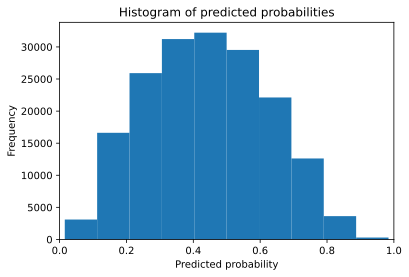

In [27]:
plt.hist(lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1])
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

(array([ 3104., 16617., 25915., 31226., 32222., 29531., 22122., 12615.,
         3635.,   299.]),
 array([0.01547799, 0.11232793, 0.20917787, 0.30602782, 0.40287776,
        0.4997277 , 0.59657765, 0.69342759, 0.79027753, 0.88712748,
        0.98397742]),
 <a list of 10 Patch objects>)

(array([163811.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  13475.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(0.0, 1.0)

Text(0.5, 1.0, 'Histogram of test data vs. prediction')

Text(0.5, 0, 'Actual data vs. predicted probability')

Text(0, 0.5, 'Frequency')

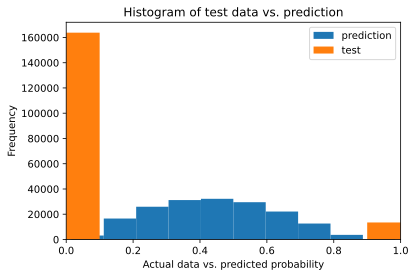

In [28]:
plt.hist(lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1], label='prediction')
plt.hist(y_test, label='test')
plt.xlim(0, 1)
plt.title('Histogram of test data vs. prediction')
plt.xlabel('Actual data vs. predicted probability')
plt.ylabel('Frequency')
plt.legend()

In [29]:
y_pred_prob_2_class6 = np.where(lgbm_2_finder_imb_rus.best_estimator_.predict_proba(X_test_3)[:,1] > 0.6, 1, 0)
print("Threshold = 0.6:")
print(metrics.classification_report(y_test, y_pred_prob_2_class6))
metrics.confusion_matrix(y_test,y_pred_prob_2_class6)

Threshold = 0.6:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87    163811
           1       0.16      0.45      0.24     13475

    accuracy                           0.78    177286
   macro avg       0.55      0.63      0.55    177286
weighted avg       0.89      0.78      0.82    177286



array([[132150,  31661],
       [  7394,   6081]])

The increse in precision was marginal compared to the decrease in recall. Not worthwhile to increase the threshold from 0.5 to 0.6, since it is more important to have a higher recall. (i.e. among 1- loans that would be bad, I captured 7 of them)